In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style

In [2]:
adata = sc.read_h5ad('../GBM_Linnarsson_EEL.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [3]:
rename_dic = {
    'GW-like 5':'GW-like Endo.Ass.',
    'GW-like 2':'GW-like Periphery1',
    'GW-like 3':'GW-like Periphery2',
    'GW-like 1':'GW-like Periphery3',
    
    'GW-like 6':'GW-like HYPR1',
    'GW-like 8':'GW-like HYPR2',
    'GW-like 7':'GW-like OPC',
    'GW-like 4':'GW-like nIPC',
    
    'nIPC-RG-like':'RG-like',
    
 
}

adata.obs['m-states3'] = pd.Categorical([rename_dic[m] if m in rename_dic else m for m in adata.obs['m-states2']])

In [4]:
adata.obs['m-states3'] = ['Endothelial' if ms.count('Endothelial') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = ['Oligodendrocyte' if ms.count('Oligodendrocyte') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = pd.Categorical(['Mural cell' if ms.count('Mural') else ms for ms in adata.obs['m-states3']])

In [5]:
adata.obs['m-states3'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'Astrocyte', 'DC', 'Endothelial',
       'Erythrocyte 1', 'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1',
       'GBL-like 2', 'GW-like Endo.Ass.', 'GW-like HYPR1', 'GW-like HYPR2',
       'GW-like OPC', 'GW-like Periphery1', 'GW-like Periphery2',
       'GW-like Periphery3', 'GW-like nIPC', 'Mono 1', 'Mono 2', 'Mural cell',
       'OPC-like 1', 'OPC-like 2', 'Oligodendrocyte', 'RG-like', 'TAM-BDM 1',
       'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'nIPC-like 1',
       'nIPC-like 2', 'nIPC-like 3', 'preOPC-like 1', 'unknown 1',
       'unknown2 1'],
      dtype='object')

In [18]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'GW-like Endo.Ass.':'#e76d89',# Deep cerise


    'GW-like nIPC':'#e76d89',# Deep cerise
    'GW-like OPC':'#e76d89',# Deep cerise
    'GW-like Periphery1': '#D6BEDD',    
    'GW-like Periphery2': '#D6BEDD',
    'GW-like Periphery3': '#D6BEDD',
    'GW-like Endo.Ass.': '#D6BEDD',
    'GW-like HYPR2': '#C50F53',
    'GW-like HYPR1': '#840034',
    
    #'nIPC-like 1':'#FFF192',
    #'nIPC-like 2':'#FFF192',
    #'nIPC-like 3':'#FFF192',
    
    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    
    'TAM-BDM 1':'#e3ba8f', #wood
    'TAM-BDM 2':'#e3ba8f',

    'Mono 1': '#c8f7c5',#'#e6d9cb',#'#cdd1e4',#'#f4ede4',
    'Mono 2': '#c8f7c5',
    
    'TAM-BDM 3':'#e8ecf1',#'#95a5a6',#'#ecd9dd',
    'TAM-BDM 4':'#dd9f57',#'#A5765C',
    'TAM-MG':'#825e5c', #'#00b5cc' (blue),
    
    
    'Oligodendrocyte':'#392e4a',
    'Astrocyte':'#038aff',
    
    #'Endothelial':'#d5b8ff', #mauve
    'Mural cell': '#8c14fc',  #electric indigo
    #'Mural': '#8c14fc',  #electric indigo
    
    'Endothelial': '#d5b8ff',  

    #'FB-like 1': '#9f5afd', #fff9de
    'FB-like 2': '#9f5afd', #fff9de
    'FB-like 3': '#9f5afd', #fff9de

}

In [7]:
import matplotlib
import seaborn as sns
greens = sns.color_palette('Greens',10)
greens = matplotlib.colors.LinearSegmentedColormap.from_list("", greens[:8])

blues = sns.color_palette('Blues',10)
blues = matplotlib.colors.LinearSegmentedColormap.from_list("", blues[:8])

In [8]:
adata.raw = adata

In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [10]:
genex = adata[:,'SPP1'].X.toarray()

In [11]:
genex.max()

8.9227915

INFO:root:First filter, 152727 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 4086 cells left
INFO:root:First filter, 150196 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 3913 cells left


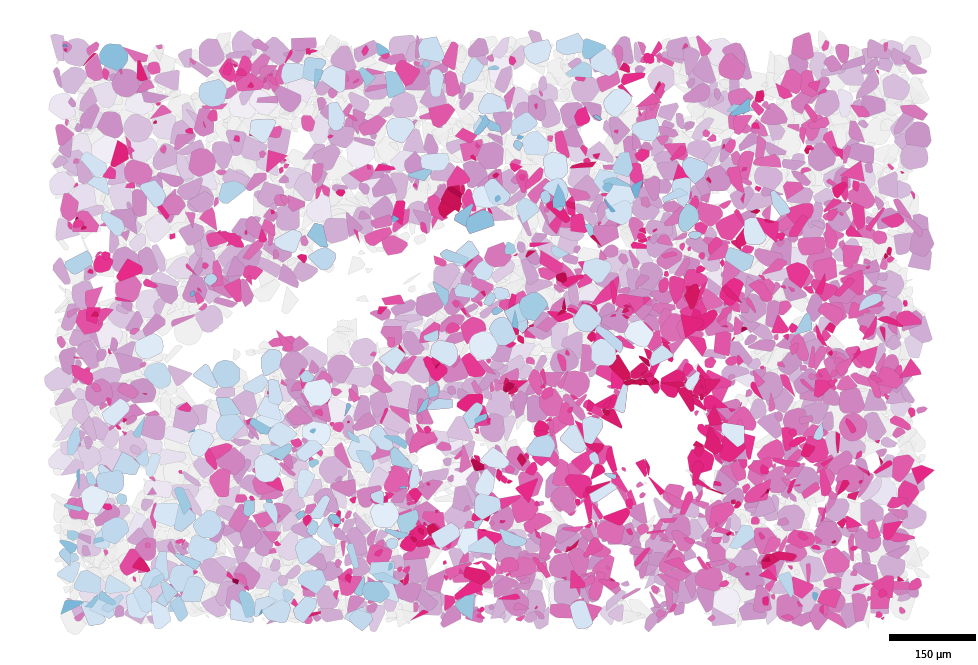

In [12]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots(1,1 ,figsize=(10,10))

#xlim=(2000,5000)
#ylim=(1800,3000)

xlim=(3500,5000)
ylim=(1800,2800)
genex = adata[:,'SPP1'].X.toarray()
sp.pl.plot_polygons_expression(
    adata,
    sample='SL001B',
    genes=['SPP1'],
    cmap='PuRd',
    cluster_key='m-states3',
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    area_min_size=5,
    mquant=.99999,
    bgval=1,
    vmax = genex.max(),
    vmin= genex[genex != 0].min(),
    
    ax = ax,

)

genex = adata[:,'IL1B'].X.toarray()
sp.pl.plot_polygons_expression(
    adata,
    sample='SL001B',
    genes=['IL1B'],
    cluster_key='m-states3',
    cmap=blues,
    plot_grays=False,
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    mquant=.999999,
    bgval=0,
    vmax = genex.max()-.5,
    vmin= genex[genex != 0].min(),
    
    ax = ax

)

plt.savefig('figures/SL001B_IL1B_SPP1.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')
plt.show()

INFO:root:First filter, 150196 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 3913 cells left


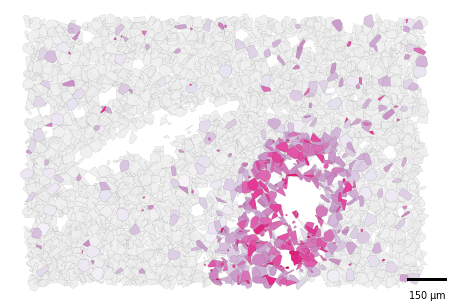

In [13]:


fig,ax = plt.subplots(1,1 ,figsize=(5,5))
xlim=(3500,5000)
ylim=(1800,2800)

genex = adata[:,'HMOX1'].X.toarray()
sp.pl.plot_polygons_expression(
    adata,
    sample='SL001B',
    genes=['HMOX1'],
    cmap='PuRd',
    cluster_key='m-states3',
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    mquant=1,
    ax = ax,
    vmax = genex.max(),
    vmin= genex[genex != 0].min(),
    
)


plt.savefig('figures/HMOX1.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')


INFO:root:First filter, 3228 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 141 cells left


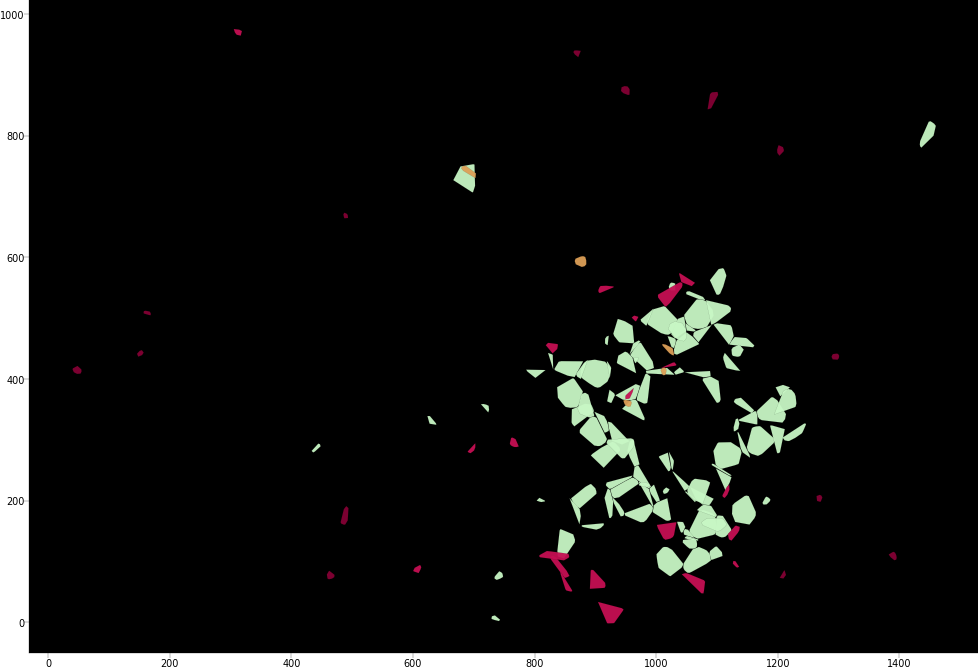

In [14]:
sp.pl.plot_polygons(
    adata,
    sample='SL001B',
    cluster_key='m-states3',
    clusters = ['Mono 1','Mono 2', 'TAM-BDM 4','GW-like HYPR1','GW-like HYPR2', 'Mural cell' ],
    
    xlim=(3500,5000),
    ylim=(1800,2800),
    show_axis=True,
    palette=palette,
    figsize=(10,10),
    alpha=0.95,
    facecolor=(0,0,0),
    annotate=False,
    area_min_size=50,
    fontsize=12,
    
    save=True,
    savepath='figures/SL001B_Mono.svg',
    
)

INFO:root:First filter, 19101 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 6640 cells left


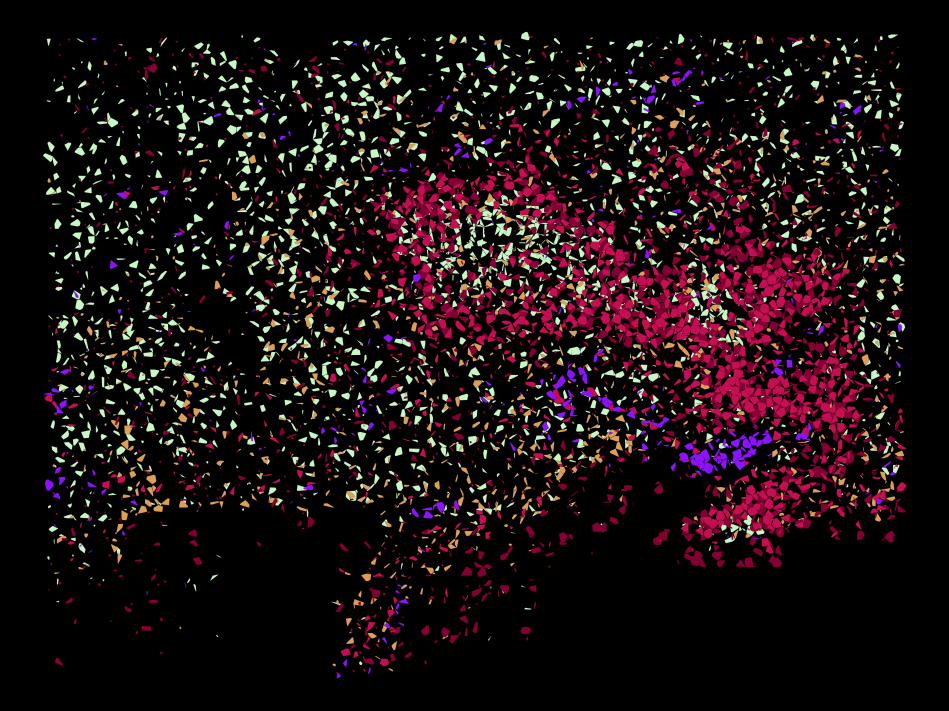

In [15]:
sp.pl.plot_polygons(
    adata,
    sample='SL046C',
    cluster_key='m-states3',
    clusters = ['Mono 1','Mono 2', 'TAM-BDM 4','GW-like HYPR1','GW-like HYPR2', 'Mural cell' ],
    xlim=(6000,10000),
    ylim=(1000,4000),

    show_axis=False,
    palette=palette,
    figsize=(10,10),
    alpha=1,
    facecolor=(0,0,0),

    area_min_size=50,
    fontsize=12,
    annotation_rotation=-90,
    annotation_text_offset=(50,-300),
    save=True,
    savepath='figures/SL046C_Mono.svg',
    
)

INFO:root:First filter, 109979 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 5670 cells left


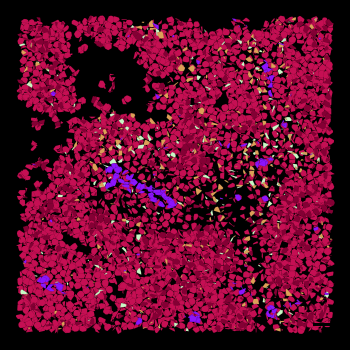

In [16]:
sp.pl.plot_polygons(
    adata,
    sample='SL035B',
    cluster_key='m-states3',
    clusters = ['GW-like HYPR2','GW-like HYPR1','Mono 1','Mono 2', 'TAM-BDM 4', 'Mural cell' ],
    xlim = (11000, 13000),
    ylim= (5000, 7000),
    show_axis=False,
    palette=palette,
    figsize=(4,4),
    alpha=1,
    facecolor=(0,0,0),
    area_min_size=50,
    fontsize=12,
    save=True, 
    show_scalebar=True,
    savepath='figures/SL035B_Mono.svg',
    
)

INFO:root:First filter, 42786 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 2950 cells left


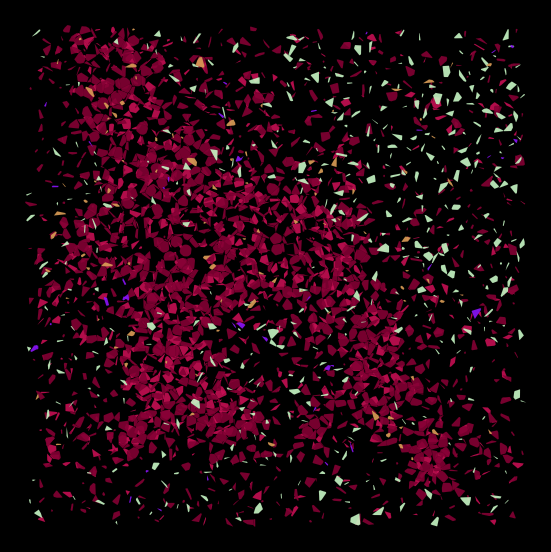

In [20]:
sp.pl.plot_polygons(
    adata,
    sample='SL061B',
    cluster_key='m-states3',
    clusters = ['GW-like HYPR2','GW-like HYPR1','Mono 1','Mono 2', 'TAM-BDM 4', 'Mural cell' ],
    xlim = (4000,6000),
    ylim = (4000,6000),
    show_axis=False,
    palette=palette,
    figsize=(6,6),
    alpha=.9,
    facecolor=(0,0,0),
    area_min_size=50,
    fontsize=12,
    save=True, 
    show_scalebar=True,
    savepath='figures/SL061B_Mono.svg',
    
)

INFO:root:First filter, 494770 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 18070 cells left
INFO:root:First filter, 494770 cells left
INFO:root:Selecting cells in zoom area
INFO:root:Zoom filter, 18070 cells left


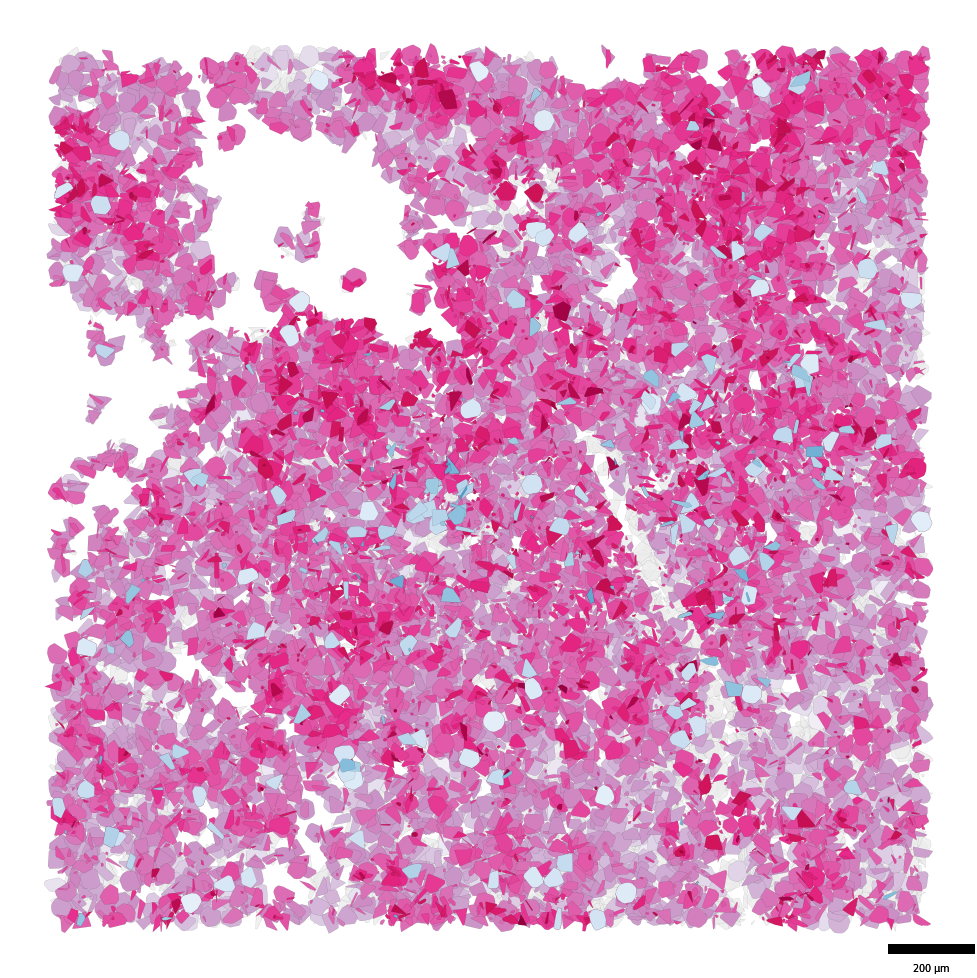

In [64]:
import matplotlib.pyplot as plt


fig,ax = plt.subplots(1,1 ,figsize=(10,10))

xlim = (11000, 13000)
ylim= (5000, 7000)

genex = adata[:,'SPP1'].X.toarray()
sp.pl.plot_polygons_expression(
    adata,
    sample='SL035B',
    genes=['SPP1'],
    cmap='PuRd',
    cluster_key='m-states3',
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    area_min_size=25,
    mquant=.99999,
    bgval=1,
    vmax = genex.max(),
    vmin= genex[genex != 0].min(),
    ax = ax,

)

genex = adata[:,'IL1B'].X.toarray()
sp.pl.plot_polygons_expression(
    adata,
    sample='SL035B',
    genes=['IL1B'],
    cluster_key='m-states3',
    cmap=blues,
    plot_grays=False,
    xlim=xlim,
    ylim=ylim,
    alpha=1,
    show_axis=False,
    mquant=.999999,
    bgval=0,
    vmax = genex.max()-.5,
    vmin= genex[genex != 0].min(),
    
    ax = ax

)

plt.savefig('figures/SL035B_IL1B_SPP1.svg',dpi=300, format='svg', transparent=True,bbox_inches='tight')
plt.show()